## Machine Learning Spring 2020
## PA3 : Multinomial Logistic Regression
### Ahmed Anwar 20110236

#### 0. Load Dependencies

In [213]:
import pandas as pd
import numpy as np
import re
import time
from tqdm.notebook import tqdm
import random
from random import sample
import matplotlib.pyplot as plt

### 1. Data Preprocessing
In this step we create the document term matrix.           

In [215]:
stopwords = ['a', 'an', 'and', 'are', 'as', 'at', 'be', 'by', 'do', 'for', 'from',
             'has', 'he', 'have', 'had', 'in', 'is', 'it', 'its', 'of', 'on', 'that', 'the',
             'to', 'was', 'where', 'will', 'with', 'she', 'i', 'me','you', 'about',
             'my', 'our', 'these', 'them', 'were','your', 'who','b','c','d','e','f','g','h',
            'j','k','l','m','n','o','p','q','r','s','t','y','u','v','w','x','z']

In [216]:
def clean_tweet(review, stopwords = stopwords):
    review = review.lower().replace(',','').replace('.','').replace('<br','').replace('/><br','').replace('/>','').replace(')','').replace('(','')
    review = review.replace(("\'"),("")).replace(";","").replace('  ',' ').replace('?',' ').replace('"', '').replace('!','').replace('  ', ' ')
    review = " ".join(filter(lambda x:x[0]!='@', review.split()))
    review = re.sub(r'[0-9]+', '', review)
    review = ' '.join([word for word in re.split("\W+", review) if word not in stopwords])
    return review

In [217]:
## convert labels to one-hots
def one_hot(Y):
    ys = np.zeros((len(Y),3))
    for i in range(len(Y)):
        label = Y[i]
        if label == 'negative':
            ys[i][0] = 1
        elif label == 'neutral':
            ys[i][1] = 1
        elif label == 'positive':
            ys[i][2] = 1
    return ys

In [218]:
def proportion(Set):
    total = pd.read_csv('Tweets.csv')
    total = total['airline_sentiment'].value_counts()
    
    subset = np.unique(Set, return_counts=True)[1]
    print('% negatives : ', round(subset[0]/total[0],3))
    print('% neutral   : ', round(subset[1]/total[1],3))
    print('% positive  : ', round(subset[2]/total[2],3))

#### 1.1 Main preprocessing function
1. Read Tweets
2. Create Vocabulary of Words
3. Clean the documents and create Vocabulary of words from Documents.  
4. Find frequency of each word in documents from the vocabulary.  
5. Build document term matrix using frequency of words.

In [240]:
def Data_Preprocessing(path):
    
    #### 1. Read Tweets ####
    tweets = pd.read_csv(path)
    tweets = tweets.sort_values('airline_sentiment').reset_index().drop(['index'], axis=1)
    counts = tweets['airline_sentiment'].value_counts()
    #sort tweets so that order is negative, neutral, positive
    
    #### 2. Create Vocabulry of words ####
    Vocabulary = []
    print('Building Vocabulary')
    for i in tqdm(range(len(tweets))):
        temp  = clean_tweet(tweets.text[i]).split()
        for j in temp:
            if j not in Vocabulary:
                Vocabulary.append(j)
        time.sleep(0.001)
    
    #### 3. Create document term matrix ###
    document_matrix = pd.DataFrame({'Vocabulary':Vocabulary})
    
    #iterate over documents
    print('Building document term matrix')
    for i in tqdm(range(len(tweets))): 
        document = clean_tweet(tweets.text[i])
        Word_freq = [0] * len(Vocabulary)

        #iterate over words in the document
        words = document.split()
        for j in range(len(words)):
            if words[j] in Vocabulary:
              #get index of which word was matched in the vocabulary
              index = Vocabulary.index(words[j])
              #increase the counter of that word in word_freq
              Word_freq[index] = Word_freq[index] + 1

        document_matrix['D'+str(i+1)] = Word_freq
        time.sleep(0.001)
            
    document_matrix.to_csv('data.csv')
    return document_matrix

## 2. Train test Split  
In this function we split the data set into training and test sets using stratified sampling.   
This function also prints the proportion of each class in the train and test sets.  

In [310]:
def train_test_split(dtm, split_size):
    
    data = dtm
    tweets = pd.read_csv('Tweets.csv')
    
    train_size = split_size
    grp = tweets.groupby('airline_sentiment').apply(lambda x: x.sample(int(train_size*len(x))))
    grp = grp.drop(['airline_sentiment','text'], axis = 1).reset_index()
    train = grp.rename(columns = {'level_1' : 'Document'})
    
    total_indices = list(range(0,len(tweets)))
    train_indices = train['Document'].tolist()
    test_indices = [x for x in total_indices if x not in train_indices]
    
    #create labels
    Y_train = one_hot(np.array(train['airline_sentiment']))
    Y_test = np.array(tweets.iloc[test_indices,:1].airline_sentiment)
    
    #create features
    temp = data
    temp = temp.drop(['Vocabulary'],axis=1)
    temp_arr = np.array(temp).T

    X_train = temp_arr[train_indices]
    X_test = temp_arr[test_indices]
    
    #### Confirm the proportions of both splits ###
    
    #In train set each category should be 80%
    print('Checking proportion of each class in train set')
    proportion(np.array(train['airline_sentiment'])) 
    print('\n')
    #In test set each category should be 20%
    print('Checking proportion of each class in test set')
    proportion(Y_test)
    
    return X_train, X_test, Y_train, Y_test

## 3. Multinomial Logistic Regression 

In [221]:
def softmax(x):
    m = len(x)
    n = 3
    sums = np.sum(np.exp(x), axis = 1)
    exps = np.exp(x)
    soft = np.zeros((m,n))
    
    for i in range(m):
        soft[i] = exps[i]/sums[i]

    return soft

#### 3.1 Categorical Cross Entropy cost function

In [222]:
def cost_function(y_pred, y_true):
    #cross entropy loss function
    return np.sum(-(y_true * np.log(y_pred)), axis =1).mean()

#### 3.2 Constructor for weight initialization

In [223]:
def initialize(features, num_classes):
    #This function initialies the weights randomly according to specific shape
    d = features.shape[1]
    k = num_classes

    weights = np.random.normal(size = (d,k))
    bias = np.zeros((1,num_classes))
    parameters = {'weights':weights, 'bias':bias}
    return parameters

#### 3.3 Forward Pass of Model

In [224]:
def predict(features, parameters):
    W = parameters['weights']
    b = parameters['bias']
    z = np.dot(features, W) + b
    return softmax(z)

#### 3.4 Gradient Descent function

In [225]:
def update_parameters(features, parameters, Y, alpha):
    
    m = len(Y)
    y_pred = predict(features, parameters)
    cost = cost_function(y_pred, Y)
    
    #gradient calculation
    error = y_pred - Y 
    d_w = np.dot(features.T, error) / m
    d_b = np.sum(error) / m

    #update parameters
    parameters['weights'] = parameters['weights'] - alpha * d_w
    parameters['bias'] = parameters['bias'] - alpha * d_b
    
    return parameters, cost 

#### 3.5 Minibatch generator

This creates a generator for yielding mini batches of features and labels. We call this function by using "next" command in our MLR function. 

In [227]:
def batch_generator(X,Y,batch_size):
    indices = np.arange(0, len(X), batch_size)
    if len(X) % batch_size != 0:
        indices = indices[:-1]
    
    while True:
        np.random.shuffle(indices)
        for index in indices:
            batch_x = X[index : index + batch_size]
            batch_y = Y[index : index + batch_size]
            yield batch_x, batch_y

#### 3.6 Main logistic regression Function

In [296]:
def MLR(features, Y , alpha, n_epoch, minibatch_size):
    
    cost_hist = list()
    parameters = initialize(features,3)

    for epoch in tqdm(range(n_epoch)):
        
        batch_loss = []
        x,y = next(batch_generator(features,Y, minibatch_size))
        
        for i in range(minibatch_size):
            parameters, loss = update_parameters(x, parameters, y, alpha) 
            batch_loss.append(loss) 
            
        cost_hist.append(np.mean(batch_loss))
        
        if np.mean(batch_loss) < 0.1: #<---threshold for minimum loss
            return parameters, cost_hist
        
        time.sleep(0.001)
              
    return parameters, cost_hist

In [229]:
def loss_plot(cost_hist):
    plt.plot(cost_hist)
    plt.title('Loss Plot')
    plt.ylabel('Cost')
    plt.xlabel('Epoch')
    plt.show()
    return 

## 4. Model Evaluation

#### 4.1 Classifation function for model outputs

In [230]:
def classifierPredict(parameters,features):
    #This function creates a crisp output of 1 and 0 from sigoid activations
    #features_norm = normalize(features)
    predictions = predict(features, parameters)
    max_index = np.argmax(predictions, axis = 1)

    ps = []
    for i in max_index:
        if i == 0:
            ps.append('negative')
        elif i == 1:
            ps.append('neutral')
        else:
            ps.append('positive')  
    
    return np.asarray(ps)

#### 4.2 Micro averaging function  

In [231]:
def micro_avg(Eval):
    TP,TN,FP,FN = 0,0,0,0
    for i in range(len(Eval)):
        FN = FN + Eval[i][1][0]
        FP = FP + Eval[i][1][1]
        TN = TN + Eval[i][1][2]
        TP = TP + Eval[i][1][3]

    precision = TP/(TP+FP)
    recall =    TP/(TP+FN)
    F1 = (2*precision*recall)/(precision+recall)
    
    return precision,recall,F1

#### 4.3 Macro averaging function

In [232]:
def macro_avg(Eval):
    Precisions = []
    Recalls = []
    F1s = []
    
    for i in range(3):
        FN = Eval[i][1][0]
        FP = Eval[i][1][1]
        TN = Eval[i][1][2]
        TP = Eval[i][1][3]

        precision = TP/(TP+FP)
        recall =    TP/(TP+FN)
        F1 = (2*precision*recall)/(precision+recall)

        Precisions.append(precision)
        Recalls.append(recall)
        F1s.append(F1)

    macro_precision = np.mean(Precisions)
    macro_recall = np.mean(Recalls)
    macro_F1 = np.mean(F1s)

    return macro_precision, macro_recall, macro_F1

I have verified evaluation metrics i.e. precision, recall and F1 score by using sk-learn library

#### 4.4 Compute Confusion Matrix

In [233]:
def confusion_matrix(y_pred,y_true):
    cmat = np.zeros((3,3), dtype = int)
    cmat[0][0] = ((y_pred == 'negative') & (y_true == 'negative')).sum()
    cmat[0][1] = ((y_pred == 'negative') & (y_true == 'neutral')).sum()
    cmat[0][2] = ((y_pred == 'negative') & (y_true == 'positive')).sum()

    cmat[1][0] = ((y_pred == 'neutral') & (y_true == 'negative')).sum()
    cmat[1][1] = ((y_pred == 'neutral') & (y_true == 'neutral')).sum()
    cmat[1][2] = ((y_pred == 'neutral') & (y_true == 'positive')).sum()

    cmat[2][0] = ((y_pred == 'positive') & (y_true == 'negative')).sum()
    cmat[2][1] = ((y_pred == 'positive') & (y_true == 'neutral')).sum()
    cmat[2][2] = ((y_pred == 'positive') & (y_true == 'positive')).sum()
    
    print('------True Labels----')
    print('     neg', ' neu', ' pos')
    print('neg', cmat[0])
    print('neu', cmat[1])
    print('pos', cmat[2])
    
    return cmat

#### 4.5 Main evaluation function 

In [234]:
def model_evaluation(parameters,X_test,Y_test, mode):
    # This function prints the evaluation metrics 
    y_pred = classifierPredict(parameters,X_test)
    y_true = Y_test

    labels = ['negative','neutral','positive']
    Eval = []
    for label in labels:
        temp = []
        for i in range(len(y_pred)):
            if y_pred[i] == label:
                  output = 'P'
            else:
                  output = 'N'
        
            #classifier predicted positive
            if output == 'P':
                if y_true[i] == label:
                    output = 'T'+ output
                else:
                    output = 'F' + output
        
            #classifier prediced negative
            if output == 'N':
                if y_true[i] == label:
                    output = 'F'+ output
                else:
                    output = 'T' + output
        
            temp.append(output)
        Eval.append(np.unique(np.array(temp), return_counts = True))
    
    cmat = confusion_matrix(y_pred,y_true)
    
    if mode == 'micro':
        precision, recall, F1 = micro_avg(Eval)
    else:
        precision, recall, F1 = macro_avg(Eval)
        
    print('\n')
    print('Model Accuracy : ', round(100*np.sum(y_pred==y_true) / len(y_pred),2), '%')   
    print('Precision : ', round(precision,3))
    print('Recall    : ', round(recall,3))
    print('F1 score  : ', round(F1,3))

## End Product

In the first step we create a document term matrix by parsing and cleaning all the tweets. We build a vocabualry of words after removing stopwords and then calculate the frequency of each word in all documents. 

In [313]:
#Step 1: Create document term matrix
dtm = Data_Preprocessing('Tweets.csv')

Building Vocabulary



Building document term matrix


This function is used to split the data set using stratified sampling

In [ ]:
#Step 2: Split Data using stratified sampling
X_train, X_test, Y_train, Y_test = train_test_split(dtm, 0.80)

We had used 80-20 split of data set. Now after the split, the training set contains 80% of total labels of each class and test set contains 20% of total labels of each class.  

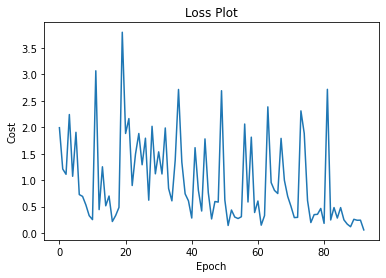

In [308]:
#Hyperparameters
alpha = 0.3
n_epoch = 100
minibatch_size = 32
random.seed(28197536)

#Step 3: Fit the model
parameters, cost_hist = MLR(X_train, Y_train, alpha, n_epoch, minibatch_size)
loss_plot(cost_hist)

The model stopped training when the desired minimum loss was achieved by the model

In [309]:
print('Minimum loss :',min(cost_hist))

Minimum loss : 0.05860408207404266


In [311]:
#Step 4: Model Evaluation
model_evaluation(parameters,X_test,Y_test, 'micro')

------True Labels----
     neg  neu  pos
neg [1618  549  428]
neu [92 30 17]
pos [126  41  28]


Model Accuracy :  57.22 %
Precision :  0.572
Recall    :  0.572
F1 score  :  0.572


In [312]:
model_evaluation(parameters,X_test,Y_test, 'macro')

------True Labels----
     neg  neu  pos
neg [1618  549  428]
neu [92 30 17]
pos [126  41  28]


Model Accuracy :  57.22 %
Precision :  0.328
Recall    :  0.33
F1 score  :  0.298


Micro averaging score is better than macro averaging because the distribution of each class is different 